In [1]:
#import scrublet as scr
import numpy as np
import pandas as pd
import statistics as st
import re
import csv
import scanpy as sc 
import scanpy.external as sce
import phate
import matplotlib
from matplotlib import pyplot as plt
import warnings
from scipy.stats import binom
from scipy.stats import multinomial
import seaborn
from scipy.stats import hypergeom
import warnings
warnings.filterwarnings('ignore')
import scrublet as scr
import harmonypy as hm

def adjust_feature(feature_matrix, feature_id):
    c, f = feature_matrix.shape
    feature_matrix = feature_matrix.copy().todense()
    
    for i in np.arange(f):
        feature_umi_array = np.asarray(feature_matrix[:,i]).squeeze()

        feature_umi_array_sort = feature_umi_array[np.argsort(feature_umi_array * -1)]
        feature_cumsum = np.cumsum(feature_umi_array_sort)

        cell_num = np.sum(feature_umi_array_sort > 0)

        turn_point = np.sum(np.diff(feature_cumsum) / np.sum(feature_umi_array) > (1 / cell_num))
        feature_matrix[np.where(feature_umi_array < feature_umi_array_sort[turn_point]), i] = 0
        
    return feature_matrix
###Paste is shift + insert
###Copy is ctrl + instert

In [2]:
working_dir = ''

In [3]:
ds = sc.read_10x_h5(working_dir + 'filtered_feature_bc_matrix.h5', gex_only=False)

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [4]:
ds.var_names_make_unique()
ds.obs_names_make_unique()

### Filter Data

In [6]:
scrub = scr.Scrublet(ds.X)

In [7]:
doublet_scores, predicted_doublets = scrub.scrub_doublets()

Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.33
Detected doublet rate = 5.6%
Estimated detectable doublet fraction = 46.2%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 12.2%
Elapsed time: 27.1 seconds


(<Figure size 576x216 with 2 Axes>,
 array([<AxesSubplot:title={'center':'Observed transcriptomes'}, xlabel='Doublet score', ylabel='Prob. density'>,
        <AxesSubplot:title={'center':'Simulated doublets'}, xlabel='Doublet score', ylabel='Prob. density'>],
       dtype=object))

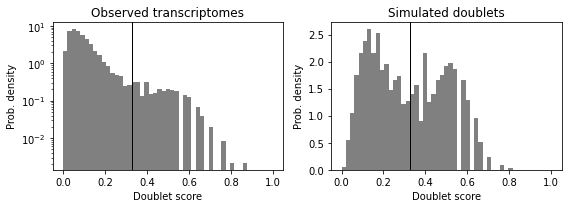

In [8]:
scrub.plot_histogram()

In [9]:
singlets = [not elem for elem in predicted_doublets]
single_ds = ds[singlets,:]

In [10]:
#merget gene index
c_num, g_num = ds.X.shape

all_singlet_idx = np.asarray(ds.obs.index)


#get the high mito cells
mt_index = ds.var.index[ds.var.index.str.startswith('MT-')].tolist()
mt_expr = np.sum(ds[:,mt_index].X, axis=1)
depth = np.sum(ds.X, axis=1)
high_mito_idx = np.argwhere((mt_expr / depth) > 0.2)[:,0].squeeze()

#get the gene and cell index
chosen_cell_index = np.setdiff1d(all_singlet_idx, all_singlet_idx[high_mito_idx])

#filter the matrix
adata = ds[chosen_cell_index, :]

sc.pp.filter_genes(adata, min_counts=1)         # only consider genes with more than 1 count
sc.pp.normalize_per_cell(adata, key_n_counts='n_counts_all') # normalize with total UMI count per cell # select highly-variable genes  # subset the genes


sc.pp.log1p(adata)
adata.raw = adata
sc.pp.scale(adata) 

Trying to set attribute `.var` of view, copying.


Text(0.5, 0, 'Mito Gene Expr (log10)')

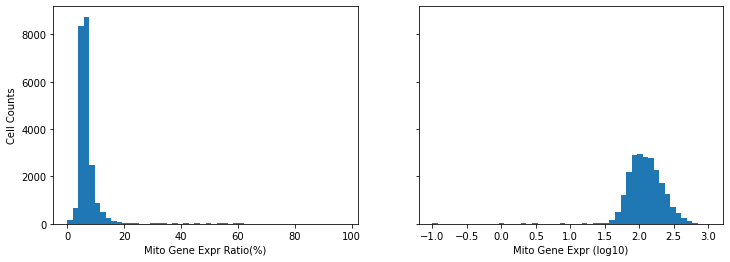

In [11]:
## check the mito gene expr
fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize=(12,4), sharey=True)
ax1.hist(mt_expr / depth * 100, bins=50)
ax1.set_xlabel('Mito Gene Expr Ratio(%)')
ax1.set_ylabel('Cell Counts')

ax2.hist(np.log10(mt_expr+0.1), bins=50)
ax2.set_xlabel('Mito Gene Expr (log10)')

In [12]:
adata.obs['library_name'] = [''] * adata.X.shape[0]
for cell_index in adata.obs.index:
    if cell_index.split('-')[-1] == '1':
        adata.obs['library_name'][cell_index] = 'DAA189'
    else:
        adata.obs['library_name'][cell_index] = 'DAA190'

### Cluster Cells

In [13]:
sc.tl.pca(adata, random_state= 0)

In [ ]:
sc.pp.neighbors(adata,use_rep='X_pca',random_state = 0)

In [ ]:
sc.tl.louvain(adata,resolution = 0.2,random_state = 0)

In [ ]:
sc.tl.paga(
    adata,
    groups='louvain', 
)

In [ ]:
sc.pl.paga(
    adata, 
    color=['louvain'], 
    use_raw=True,
    layout='fr',
    threshold=0.01,
    node_size_scale=0.5,
    node_size_power=0.9,
    edge_width_scale=1,
)

In [ ]:
sc.tl.umap(
    adata,
    init_pos='paga',
    random_state = 0
)

In [ ]:
sc.pl.umap(
    adata,
    color=['louvain'], 
    vmin=0, vmax= 100
)

In [ ]:
fig, ax = plt.subplots(figsize=(12,10))
sc.pl.umap(
    adata, 
    color=['TNNT2'],
        size=50,
            use_raw=False,
    ax=ax
)

In [ ]:
sc.tl.rank_genes_groups(adata, 'louvain', method='wilcoxon')

In [ ]:
sc.pl.rank_genes_groups(adata)

In [ ]:
### Remove small cluster (only 7 cells)
adata = adata[adata.obs.louvain != '7']

### Combine Neuronal Clusters Into One

In [ ]:
orig_louvain = ['0', '2', '4', '1', '3', '5', '6']
new_louvain = ['0', '0', '0', '1', '2', '2', '3']
#0=nerual
#1=endoderm
#2=cardiac
#3=all else
louvain_changes = dict(zip(orig_louvain, new_louvain))

In [ ]:
new_id = []
for index in adata.obs.index:
    current_id = adata.obs.louvain[index]
    updated_id = louvain_changes[current_id]
    new_id.append(updated_id)

In [ ]:
adata.obs['louvain'] = new_id

In [ ]:
sc.tl.rank_genes_groups(adata, 'louvain', method='wilcoxon')

In [ ]:
sc.pl.rank_genes_groups(adata)

In [ ]:
adata.write('./Focused_SC_091121.h5ad')

### Load and Remove SG Cells

In [ ]:
SG_DF = pd.read_pickle('./Focused_SGRNA_IND_091121.pkl')

In [ ]:
SG_DF_Grouped = pd.read_pickle('./Focused_SGRNA_IND_091121_GROUP.pkl')

In [ ]:
sg_pos = []
for cell in adata.obs.index:
    try:
        if sum(SG_DF.loc[cell] > 0) > 0:
            sg_pos.append(cell)
    except:
        continue
SG_DF = SG_DF.loc[sg_pos]
SG_DF_Grouped = SG_DF_Grouped.loc[sg_pos]

In [ ]:
SG_DF.to_pickle('./Focused_SGRNA_IND_SC_091121.pkl')

In [ ]:
SG_DF_Grouped.to_pickle('./Focused_SGRNA_IND_091121_GROUP_SC.pkl')